# How to read data from BigQuery

This notebook demonstrates two ways to use BigQuery with R
1. by using SQL
2. by using only R code to extract the data of interest from BigQuery

## Setup

First, be sure to run notebook **`R environment setup`** in this workspace.

Then in this section we:

1. load the needed R packages
2. set the project id of the cloud project to bill for queries to BigQuery
3. authorize our bigquery client library to issue requests

In [1]:
# Load the libraries into memory
library(bigrquery)
library(dplyr)
library(skimr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘skimr’

The following object is masked from ‘package:stats’:

    filter



In [2]:
# Authorize bigrquery client
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')
bigrquery::set_service_token(Ronaldo::getServiceAccountKey())

## Retrieve filtered data.
Let’s retrieve a subset of fields and samples in metadata for [1000 Genomes](http://www.internationalgenome.org/data "1000 Genomes").

We can do this in two different ways and they both return the exact same results

1. using SQL and bigrquery
2. using dplyr and dbplyr

### Option 1: Retrieve filtered data from BigQuery using bigrquery.
To learn more about SQL syntax see the [BigQuery standard SQL reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/).

In [3]:
# Run a query 
phase1_samples_tbl <- bigrquery::bq_project_query(
    BILLING_PROJECT_ID,
    query = '
SELECT
  Sample,
  Gender,
  Relationship,
  Population,
  Population_Description,
  Super_Population,
  Super_Population_Description,
  Total_Exome_Sequence,
  Main_Project_E_Platform,
  Main_Project_E_Centers
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
WHERE
  -- Only include information for samples in phase 1.
  In_Phase1_Integrated_Variant_Set = TRUE
  -- Only include information for samples with these relationships.
  AND Relationship IN ("", "unrel", "child", "father", "mother",
  "mat grandmother", "pat grandmother",
  "mat grandfather", "pat grandfather")
')

phase1_samples <- bigrquery::bq_table_download(phase1_samples_tbl)

In [4]:
dim(phase1_samples)

[1] 1086   10

In [5]:
print(skim(phase1_samples))

Skim summary statistics
 n obs: 1086 
 n variables: 10 

── Variable type:character ─────────────────────────────────────────────────────
                     variable missing complete    n min max empty n_unique
                       Gender       0     1086 1086   4   6     0        2
       Main_Project_E_Centers       0     1086 1086   0   5    23        5
      Main_Project_E_Platform       0     1086 1086   0   8    23        2
                   Population       0     1086 1086   3   3     0       14
       Population_Description       0     1086 1086  16  58     0       14
                 Relationship       0     1086 1086   0  15   559        8
                       Sample       0     1086 1086   7   7     0     1086
             Super_Population       0     1086 1086   3   3     0        4
 Super_Population_Description       0     1086 1086   7  10     0        4

── Variable type:numeric ───────────────────────────────────────────────────────
             variable missing 

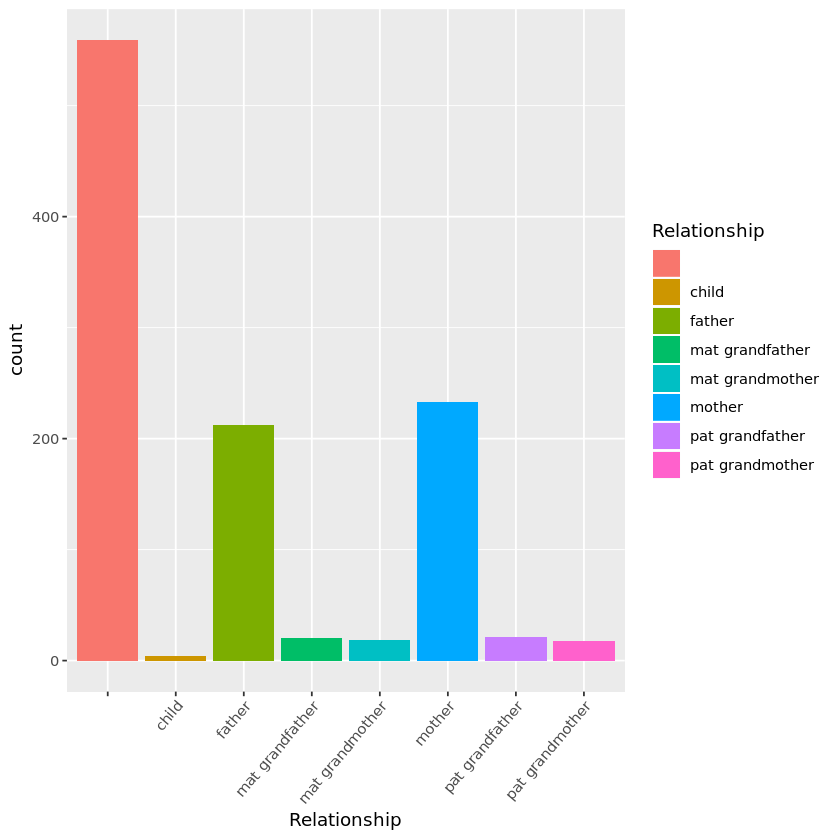

In [6]:
ggplot(data = phase1_samples,
       aes(x=Relationship, fill=Relationship)) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1, vjust = 1))

### Option 2: Retrieve filtered data from BigQuery using dplyr.
To learn more about dplyr see [R for Data Science Chapter 5 Data transformation](http://r4ds.had.co.nz/transform.html "Chapter 5").

In [7]:
# Create a "connection" to a public BigQuery dataset.
dbcon <- bigrquery::src_bigquery(project = 'bigquery-public-data',
                                 dataset = 'human_genome_variants',
                                 billing = BILLING_PROJECT_ID)

# Create a 'virtual dataframe' backed by a BigQuery table.
sample_info <- dplyr::tbl(dbcon, '1000_genomes_sample_info')

In [8]:
phase1_only <- sample_info %>% filter(
    In_Phase1_Integrated_Variant_Set == TRUE,
    Relationship %in% c(
      '', 'unrel', 'child', 'father', 'mother',
      'mat grandmother', 'pat grandmother',
      'mat grandfather', 'pat grandfather')
  )
# Nothing is computed on BigQuery yet.

In [9]:
sample_fields <- phase1_only %>% select(
  Sample,
  Gender,
  Relationship,
  Population,
  Population_Description,
  Super_Population,
  Super_Population_Description,
  Total_Exome_Sequence,
  Main_Project_E_Platform,
  Main_Project_E_Centers
  )
# Still nothing computed on BigQuery.

In [10]:
# Optional: take a look at the SQL.
dplyr::show_query(sample_fields)

<SQL>
SELECT `Sample`, `Gender`, `Relationship`, `Population`, `Population_Description`, `Super_Population`, `Super_Population_Description`, `Total_Exome_Sequence`, `Main_Project_E_Platform`, `Main_Project_E_Centers`
FROM `1000_genomes_sample_info`
WHERE ((`In_Phase1_Integrated_Variant_Set` = TRUE) AND (`Relationship` IN ('', 'unrel', 'child', 'father', 'mother', 'mat grandmother', 'pat grandmother', 'mat grandfather', 'pat grandfather')))


In [11]:
# Optional: See how much data this will return.
sample_fields %>% summarize(cnt = n()) %>% collect()

cnt
1086


In [12]:
# Execute the query and return all results into an in-memory table in R.
phase1_samples <- sample_fields %>% collect()

In [13]:
dim(phase1_samples)

[1] 1086   10

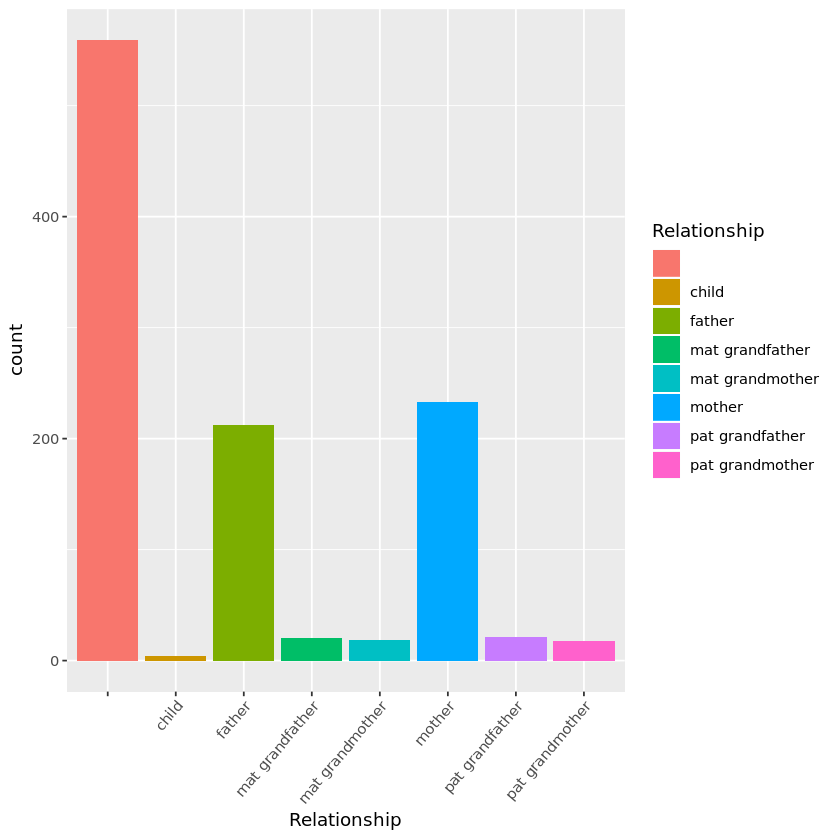

In [14]:
ggplot(data = phase1_samples,
       aes(x=Relationship, fill=Relationship)) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1, vjust = 1))

# Provenance

In [15]:
devtools::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 3.5.2 (2018-12-20)
 os       Debian GNU/Linux 9 (stretch)
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2019-04-30                  

─ Packages ───────────────────────────────────────────────────────────────────
 package     * version     date       lib
 askpass       1.1         2019-01-13 [2]
 assertthat    0.2.1       2019-03-21 [2]
 backports     1.1.4       2019-04-10 [1]
 base64enc     0.1-3       2015-07-28 [2]
 bigrquery   * 1.1.0       2019-02-05 [2]
 bit           1.1-14      2018-05-29 [2]
 bit64         0.9-7       2017-05-08 [2]
 callr         3.2.0       2019-03-15 [2]
 cli           1.1.0       2019-03-19 [2]
 colorspace    1.4-1       2019

Copyright 2018 The Broad Institute, Inc., Verily Life Sciences, LLC All rights reserved.

This software may be modified and distributed under the terms of the BSD license. See the LICENSE file for details.